In [1]:
# enable automatic reloading of the notebook
%load_ext autoreload
%autoreload 2

# Tutorial: Overview
This notebook provides a demonstration how the ts2g2 library can be used to convert time series into graphs and graphs into time series, with links to more detailed tutorials. To that end, we use a dataset with the history of daily prices of Amazon stock (AMZN) and Apple stock (APPLE). All the column descriptions are provided. Currency is USD.

In [2]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import matplotlib.pyplot as plt
from core.model import Timeseries, TimeseriesPreprocessing, TimeseriesPreprocessingSegmentation, TimeseriesPreprocessingSlidingWindow, TimeseriesPreprocessingComposite, TimeseriesView, TimeGraph, ToSequenceVisitorSlidingWindow, ToSequenceVisitor, ToSequenceVisitorOrdinalPartition
from tsg_io.input import CsvFile
from from_graph.strategy_to_time_sequence import StrategyNextValueInNodeRandom, StrategyNextValueInNodeRandomForSlidingWindow, StrategyNextValueInNodeRoundRobin, StrategyNextValueInNodeRoundRobinForSlidingWindow, StrategySelectNextNodeRandomlyFromNeighboursAcrossGraphs, StrategySelectNextNodeRandomlyFromNeighboursFromFirstGraph, StrategySelectNextNodeRandomly, StrategySelectNextNodeRandomDegree, StrategySelectNextNodeRandomWithRestart, StrategyNextValueInNodeOrdinalPartition
from to_graph.strategy_linking_graph import StrategyLinkingGraphByValueWithinRange, LinkNodesWithinGraph
from to_graph.strategy_linking_multi_graphs import LinkGraphs
from to_graph.strategy_to_graph import BuildTimeseriesToGraphNaturalVisibilityStrategy, BuildTimeseriesToGraphHorizontalVisibilityStrategy, BuildTimeseriesToGraphOrdinalPartition, BuildTimeseriesToGraphQuantile
import warnings
warnings.filterwarnings('ignore')

## Loading data 
We first load the dataset :)

In [3]:
amazon_path = os.path.join(os.getcwd(), "amazon", "AMZN.csv")
apple_path = os.path.join(os.getcwd(), "apple", "APPLE.csv")


In [4]:
def plot_timeseries(sequence, title, x_legend, y_legend, color = "black"):
    plt.figure(figsize=(10, 6))
    plt.plot(sequence, linestyle='-', color=color)
    
    plt.title(title)
    plt.xlabel(x_legend)
    plt.ylabel(y_legend)
    plt.grid(True)
    plt.show()

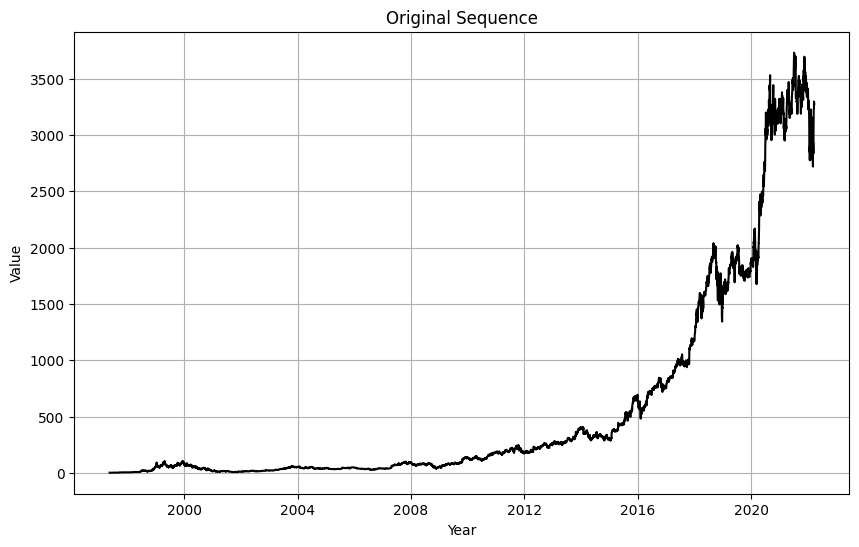

In [5]:
plot_timeseries(CsvFile(amazon_path, "Close").from_csv(), "Original Sequence", "Year", "Value")

For easier presentation and understanding we will only analyze a segment of this timeseries.

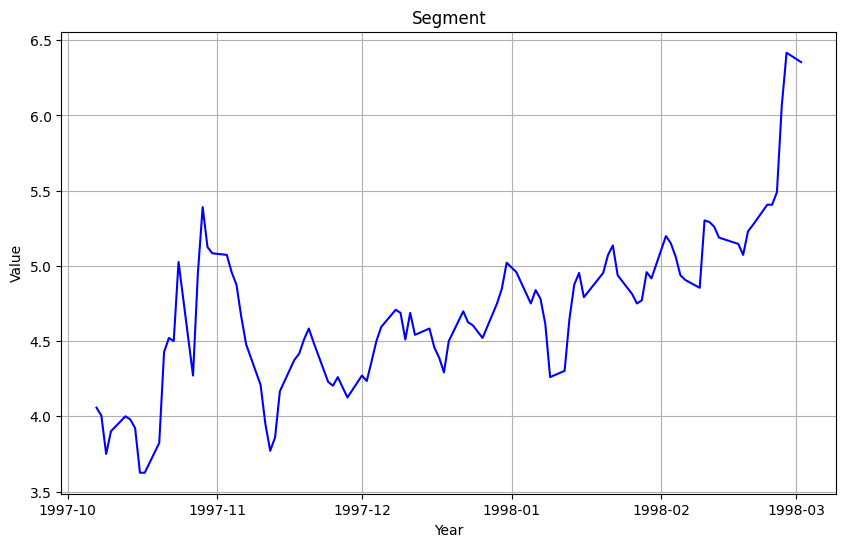

In [6]:
plot_timeseries(CsvFile(amazon_path, "Close").from_csv()[100:200], "Segment", "Year", "Value", color="blue")

## Univariate graphs
We can now turn this segment of timeseries into a univariate graph:

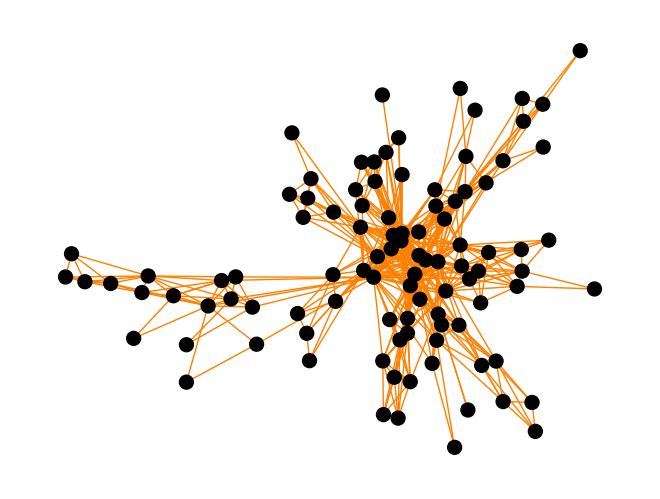

In [7]:
timegraph = Timeseries(CsvFile(amazon_path, "Close").from_csv())\
    .with_preprocessing(TimeseriesPreprocessingSegmentation(100, 200))\
    .to_graph(BuildTimeseriesToGraphNaturalVisibilityStrategy().get_strategy())\
    .draw()

## Multivariate graphs

If we have multiple segments of timeseries, we can turn them into one connected graph, based on given strategy:

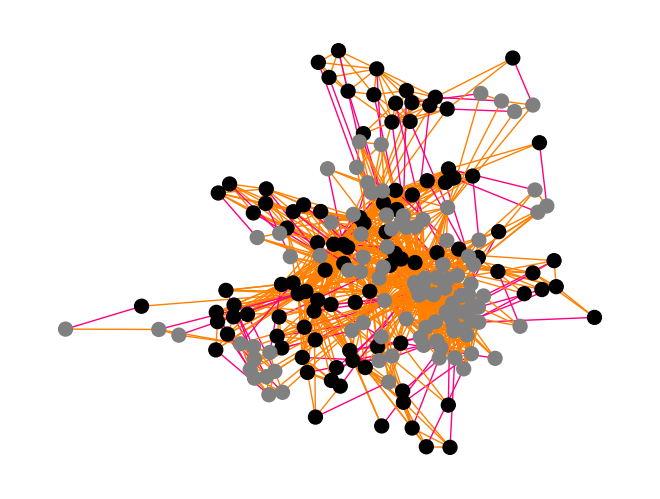

In [8]:
multivariate_timegraph = Timeseries(CsvFile(amazon_path, "Close").from_csv())\
    .with_preprocessing(TimeseriesPreprocessingSegmentation(100, 200))\
    .add(Timeseries(CsvFile(amazon_path, "Close").from_csv())\
         .with_preprocessing(TimeseriesPreprocessingSegmentation(200, 300)))\
    .to_graph(BuildTimeseriesToGraphNaturalVisibilityStrategy().get_strategy())\
    .link(LinkGraphs().time_cooccurrence())\
    .draw()

## About graphs

There are multiple of different methods of turning timeseries into graphs. So far we have implemented:

- **Natural visibility strategy**: based on the idea that each observation of the time series is seen as a vertical bar with height equal to the numerical value of the observation and that these vertical bars are laid in a landscape, the top of a bar is visible from the tops of other bars. Each node in the graph corresponds to a time stamp *t* of the time series, so the nodes are serially ordered. Two nodes are connected if there is a line of visibility between the corresponding data bars that is not intercepted.

- **Horizontal visibility strategy**: a simplified natural visibilit method called the horizontal visibility graph inherits all natural visibility graph characteristics. The construction of horizontal visibility graphs differs from that of natural visibility graphs in that the visibility lines are only horizontal. 

- **Strategy using quantiles**: based on the idea of assigning the time series observations to bins.

- **Ordinal partition strategy**: based on the idea of a set of sequential patterns defined for a sequence of consecutive observations, where each node of the network represents one of the defined patterns and the edges are weighted according to the transition frequency between two consecutive patterns.

- **Proximity network strategy**: mappings based on the concept of proximity use measures of distance or similarity to calculate the distance between the points of the time series incorporated in the multidimensional phase space. These methods map states of the time series into nodes of the network and create edges between those nodes based on some measure of distance or similarity.

- **Timeseries correlation strategy**: one of ways of comparing timeseries between themselves, can be explored with help of timeseries to graph conversion techniques.
    

Along with these strategies, we have constructed strategy, to turn timeseries into a 

- **Sliding window graph**: a special type of graph, that is made of multiple subgraphs, connected in sequential order.

After we have turned our segment into a graph, we can furthrt supplement our graph with some methods like:

- add_edge(node_1, node_2, weight=None): adds edge between node_1 and node_2 with weight weight if it is not none.

- link(link_strategy: LinkNodesWithinGraph): links nodes in graph based on a link_strategy object.

- combine_identical_nodes(): combines nodes that have the same attributes.

# To timeseries

When we have our graph, we can also generate a timeseries from it.

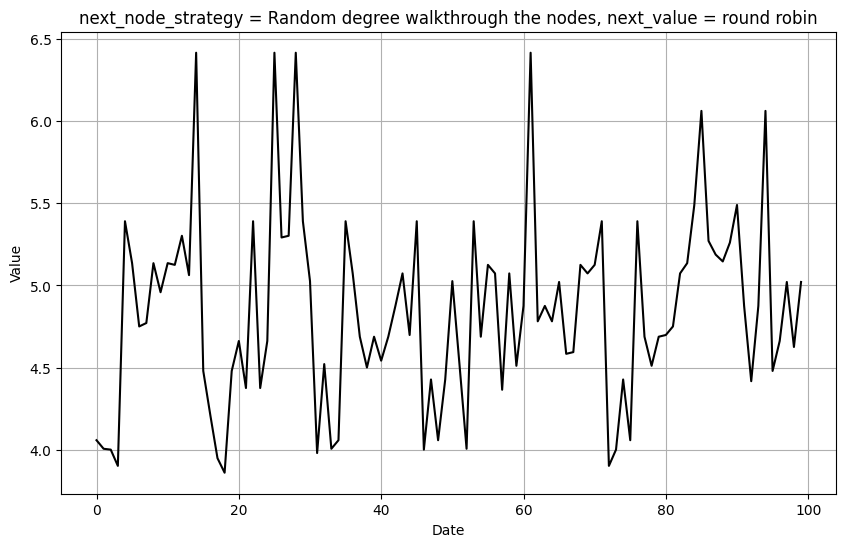

In [9]:
timegraph.to_sequence(ToSequenceVisitor()\
        .next_node_strategy(StrategySelectNextNodeRandomDegree())\
        .next_value_strategy(StrategyNextValueInNodeRoundRobin())\
        .ts_length(100))\
    .draw_sequence()

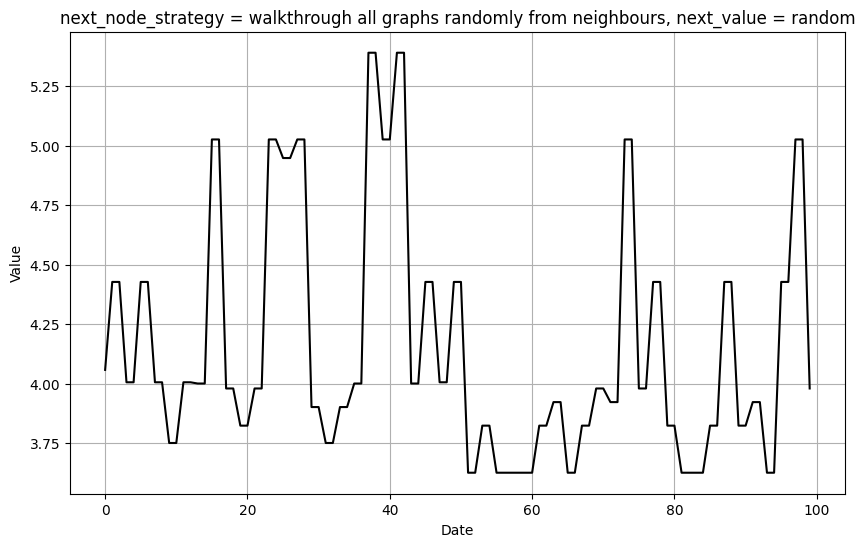

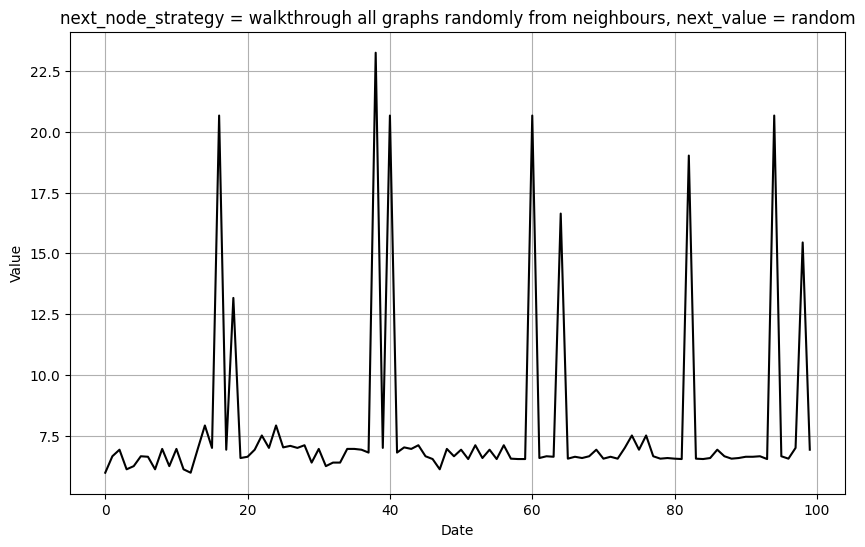

In [10]:
multivariate_timegraph.to_sequence(ToSequenceVisitor()\
        .next_node_strategy(StrategySelectNextNodeRandomlyFromNeighboursAcrossGraphs())\
        .next_value_strategy(StrategyNextValueInNodeRandom())\
        .ts_length(100))\
    .draw_sequence()

There are also many different ways of generating timeseries. You can take closer look at them here: [Graph to timeseries generation strategies](https://timeseriestographs.com/tutorial/tutorial-g2ts-strategies/)

A compact tutorial of different timeseries to graph and back methods along with some extra functions can be found here: [Compact tutorial](https://timeseriestographs.com/tutorial/tutorial-ts2g2-compact/)

# Timeseries and graph embeddings
We can compare different graphs and timeseries among each other by creating and calculating distance between their embeddings.
You can take a closer look how this is done here: [Embeddings](https://timeseriestographs.com/tutorial/tutorial-ts2g2-embeddings/)